In [1]:
import pandas as pd
import numpy as np
import os

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import gc
import warnings

In [2]:
import matplotlib.pyplot as plt

In [3]:
#!pip install matplotlib

In [11]:
cwd = os.getcwd()
PARENTDIR = os.path.split(os.path.split(cwd)[0])[0]
DATADIR = os.path.join(PARENTDIR, 'Capstone-WebApp-backup/models')
CSV_file = ("Dataset-for-ML-Model.csv")
frame = pd.read_csv(os.path.join(DATADIR, CSV_file), encoding = "ISO-8859-1")

In [12]:
# Note: this function requires a cleaned up 'location' column with no NaN or empty strings
def get_city_state(df):
    df["state"] = df["location"].str.split().str[-1]
    df["location"].apply(lambda x: "".join(x.split()[1:]))
    df["location"] = df["location"].apply(lambda x: x.split(" "))
    df["city"] = df["location"].str[:-1].apply(lambda x: " ".join(x))
    
    df = df[['employer', 'job title', 'base salary', 'submit date',
       'start date', 'case status', 'submit year', 'submit month', 'state', 'city']]
    
    return df

In [13]:
frame = get_city_state(frame)

In [14]:
X = frame[['employer', 'job title', 'submit year', 'state', 'city']]
y = np.log1p(frame[['base salary']].values)

### Label Encoding

Multiple label enconding per: https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn/47100771#47100771

Note: investigate later how to save the default dict to a JSON file so I can 1) load it back later if loading the model (pickle) elsewhere.

In [15]:
from collections import defaultdict

In [16]:
d = defaultdict(LabelEncoder)
cols_to_transf = ['employer','job title','state','city']

In [17]:
def fit_and_transform(df,cols_to_transf):
    df_transf = df[cols_to_transf]
    df_non_transf = df.drop(cols_to_transf, axis = 1)
    
    fit = df_transf.apply(lambda x: d[x.name].fit_transform(x))
    
    df = pd.concat([fit, df_non_transf], axis=1, join='outer')
    return df

In [18]:
def inverse_encoding(df,encoded_cols):
    df_inverse = df[encoded_cols]
    df_non_inv = df.drop(encoded_cols, axis = 1)
    
    df_inverse = df_inverse.apply(lambda x: d[x.name].inverse_transform(x))
    df = pd.concat([df_inverse, df_non_inv], axis=1, join='outer')
    
    return df

In [19]:
def encode_future_data(df,cols_to_transf):
    df_transf = df[cols_to_transf]
    df_non_transf = df.drop(cols_to_transf, axis = 1)
    
    fit = df_transf.apply(lambda x: d[x.name].transform(x))
    
    df = pd.concat([fit, df_non_transf], axis=1, join='outer')
    return df

In [20]:
X = fit_and_transform(X, cols_to_transf)

### Saving label encoder classes for re-use in app

In [21]:
for key in d.keys():
    filename = '{}.npy'.format(key)
    filename = filename.replace(' ','_')
    np.save(filename, d[key].classes_)

In [22]:
test_size = 0.25 # assign proportion of dataset to test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

del X, y; gc.collect()

35

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [24]:
future_data_column_order = ['employer', 'job title', 'state', 'city', 'submit year']
# ['employer', 'job title', 'submit year', 'state', 'city']
# ['employer', 'job title', 'state', 'city', 'submit year']

In [25]:
X_test.columns

Index(['employer', 'job title', 'state', 'city', 'submit year'], dtype='object')

In [26]:
d_train = xgb.DMatrix(X_train, label = y_train)
d_valid = xgb.DMatrix(X_valid, label = y_valid)

del X_train, X_valid; gc.collect()

34

In [27]:
params = {"objective": "reg:linear",
          "learning_rate": 0.1, 
          "max_depth": 5, 
          "min_child_weight": 2,
          "eval_metric": "rmse",
          "silent": 1,
          "colsample_bytree": 0.7}

In [30]:
#watchlist = [(d_train, 'train'), (d_valid, 'valid')]
#clf = xgb.train(params, d_train, num_boost_round=10000, evals=watchlist,early_stopping_rounds=20,verbose_eval=200)

In [29]:
import pickle

In [23]:
#with open("TDI-XGB_model.pkl", "wb") as f:
#    pickle.dump(clf, f)

In [31]:
with open("TDI-XGB_model.pkl", "rb") as f:
    clf = pickle.load(f)

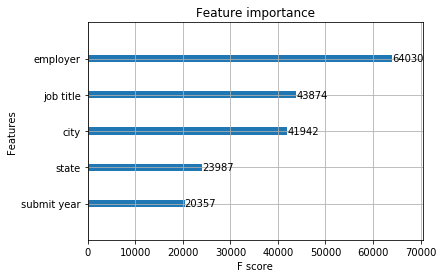

In [32]:
xgb.plot_importance(clf)

### Verify test set

In [33]:
d_test = xgb.DMatrix(X_test)

In [34]:
predict = clf.predict(d_test)

In [35]:
print('Prediction RMSE = {:.4f}'.format(np.sqrt(mean_squared_error(y_test, predict))))
print('R2 = {:.3f}'.format(r2_score(y_test, predict)))

Prediction RMSE = 0.1568
R2 = 0.753


### Check predictions

In [36]:
#X_test.head(2)

In [37]:
predict_dict = {
    'employer':     ['Google Inc', 'Georgia Institute of Technology','Ove Arup & Partners PC'],
    'job title':    ['Data Scientist', 'Assistant Professor', 'Mechanical Engineer'],
    'state':        ['NY', 'GA', 'NY'],
    'city':         ['New York', 'Atlanta', 'New York'],
    'submit year':  [2018, 2018, 2018]}

In [42]:
def preprocess_new_data(predict_dict,cols_to_transf,future_data_column_order):
    predict_df = pd.DataFrame.from_dict(predict_dict)
    predict_df_transf = predict_df[cols_to_transf]
    predict_df_non_transf = predict_df.drop(cols_to_transf, axis=1)
    
    for col in predict_df_transf.columns:
        predict_df_transf[col] = predict_df_transf[col].str.upper()
    
    predict_df = pd.concat([predict_df_transf, predict_df_non_transf], axis=1, join='outer')
    
    predict_df = encode_future_data(predict_df,cols_to_transf)
    
    predict_df = predict_df[future_data_column_order]
    
    return predict_df

In [39]:
predict_df = preprocess_new_data(predict_dict, cols_to_transf,future_data_column_order)

/home/pablo/PycharmProjects/Capstone-WebApp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [40]:
d_new_data = xgb.DMatrix(predict_df)
new_predictions = clf.predict(d_new_data)

In [41]:
for i, title in enumerate(predict_dict['job title']):
    print('Your predicted salary as ' + title.title() + ' at ' + predict_dict['employer'][i] +
          ' in ' + predict_dict['city'][i] + ' is ' + '${:,.0f}'.format(int(np.expm1(new_predictions[i]))))

Your predicted salary as Data Scientist at Google Inc in New York is $150,212
Your predicted salary as Assistant Professor at Georgia Institute of Technology in Atlanta is $107,958
Your predicted salary as Mechanical Engineer at Ove Arup & Partners PC in New York is $81,461


### Export location, employer, job title lists for use in app
Only entries with counts > 10 will be exported to avoid too many items in the app dropdown menu, which slows down the app significantly

In [122]:
import re

***Locations***

In [79]:
frame['location'] = frame['city']+ ', '  + frame['state']

In [80]:
locations = frame[['location']]

In [81]:
location_counts = frame['location'].value_counts().reset_index().rename(columns={'location': 'counts', 'index': 'location'})

In [82]:
locations = locations.merge(location_counts, on='location')

In [83]:
locations = locations[locations['counts'] > 10]

In [85]:
unique_locations = sorted(set(locations['location']))

In [88]:
print(len(set(frame['location'])))
print(len(unique_locations))

13994
3262


***Job Titles***

In [101]:
job_titles = frame[['job title']]

In [102]:
job_title_counts = frame['job title'].value_counts().reset_index().rename(columns={'job title': 'counts', 'index': 'job title'})

In [103]:
job_titles = job_titles.merge(job_title_counts, on='job title')
job_titles = job_titles[job_titles['counts'] > 10]
unique_job_titles = sorted(set(job_titles['job title']))

In [104]:
print(len(set(frame['job title'])))
print(len(unique_job_titles))

7722
400


***Companies***

In [113]:
companies = frame[['employer']]

In [114]:
companies_counts = frame['employer'].value_counts().reset_index().rename(columns={'employer': 'counts', 'index': 'employer'})

In [115]:
companies = companies.merge(companies_counts, on='employer')
companies = companies[companies['counts'] > 10]
unique_companies = sorted(set(companies['employer']))

In [116]:
print(len(set(frame['employer'])))
print(len(unique_companies))

78673
9421


In [119]:
def remove_duplicate_state_abbr(location_list):
    for location in location_list:
        if re.match('[\w]+',location[0]):
            duplicate_chk = re.findall('[\w]+',location[0])
            for item in duplicate_chk:
                if item == location[1].strip():
                    try:
                        location[0] = location[0].replace(item,'')
                    except TypeError:
                        continue
    return location_list

In [120]:
def cleanup_locations(location_list):
    location_list = [''.join(c for c in string if not c.isdigit()) for string in location_list]
    location_list = [location.replace('#','') for location in location_list]
    location_list = [location.replace('MSA','') for location in location_list]
    location_list = [location.replace('DIV','') for location in location_list]
    location_list = [location.replace('&NBSP','') for location in location_list]
    location_list = [location.replace(';','') for location in location_list]
    location_list = [location.replace(':','') for location in location_list]
    location_list = [location.strip() for location in location_list]
    location_list = [location.split(',') for location in location_list]
    #location_list = [location for location in location_list if location not in wrongly_mispelled_locations]
    location_list = remove_duplicate_state_abbr(location_list)
    location_list = [location for location in location_list if len(location[0]) > 0]
    location_list = [[re.sub(' +', ' ', location[0]), location[1]] for location in location_list]
    location_list = sorted(location_list, key=lambda x: x[1])
    location_list = [','.join(item) for item in location_list]
    location_list = sorted(set(location_list), key=location_list.index)
    return location_list

In [130]:
print(len(unique_locations))
unique_locations = cleanup_locations(unique_locations)
print(len(unique_locations))

3254
3254


In [127]:
#unique_locations2[:55]

In [131]:
with open('locations-list.txt', 'w') as f:
    for item in unique_locations:
        f.write('%s\n' % item)

In [133]:
with open('employers-list.txt', 'w') as f:
    for item in unique_companies:
        f.write('%s\n' % item)

In [134]:
with open('job-titles-list.txt', 'w') as f:
    for item in unique_job_titles:
        f.write('%s\n' % item)

In [ ]:
`